# NB04: Essential Genes vs Pangenome Conservation

Are essential genes preferentially conserved (core) in the pangenome?

**Essential gene definition**: Protein-coding genes (type=1) with no entries in `genefitness`.
In RB-TnSeq, this means no viable transposon mutants were recovered — the gene is required
for viability. This is an upper bound; some genes may lack insertions due to being short or
in regions with poor transposon coverage.

**Data extraction** was performed by `src/extract_essential_genes.py` (Spark Connect):
```python
# For each organism, two queries identify essential genes:
# 1. All protein-coding genes:
#    SELECT orgId, locusId, begin, end, gene, desc
#    FROM kescience_fitnessbrowser.gene WHERE orgId='{org}' AND type='1'
#
# 2. Genes with fitness data:
#    SELECT DISTINCT orgId, locusId
#    FROM kescience_fitnessbrowser.genefitness WHERE orgId='{org}'
#
# Essential = genes in (1) but NOT in (2)
#
# Also extracted: SEED annotations (seedannotation), KEGG annotations
# (besthitkegg + keggmember + kgroupdesc), and pangenome metadata.
```

**Note on FB schema**: After checking all 45 tables in `kescience_fitnessbrowser`, there is no
explicit essentiality flag or insertion count column. The `gene.type` column encodes feature
type (1=CDS, 5=pseudo, 7=rRNA, 2=tRNA). The only way to identify putative essential genes
is by absence from `genefitness`.

**Inputs** (cached from extraction):
- `data/essential_genes.tsv` — per-gene essentiality + gene length
- `data/fb_pangenome_link.tsv` — gene-to-cluster links with conservation status
- `data/pangenome_metadata.tsv` — clade size, openness metrics, GTDB taxonomy
- `data/seed_annotations.tsv` — SEED functional annotations from FB
- `data/kegg_annotations.tsv` — KEGG functional annotations from FB

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path

DATA_DIR = Path('../data')
FIGURES_DIR = Path('../figures')
FIGURES_DIR.mkdir(exist_ok=True)

# Load data
essential = pd.read_csv(DATA_DIR / 'essential_genes.tsv', sep='\t')
link = pd.read_csv(DATA_DIR / 'fb_pangenome_link.tsv', sep='\t')
pg_meta = pd.read_csv(DATA_DIR / 'pangenome_metadata.tsv', sep='\t')
mapping = pd.read_csv(DATA_DIR / 'organism_mapping.tsv', sep='\t')

print(f"Essential genes data: {len(essential):,} genes across {essential['orgId'].nunique()} organisms")
print(f"Link table: {len(link):,} gene-cluster links")
print(f"Pangenome metadata: {len(pg_meta)} clades")

/tmp/ipykernel_109376/229369503.py:12: DtypeWarning: Columns (0: gene) have mixed types. Specify dtype option on import or set low_memory=False.
  essential = pd.read_csv(DATA_DIR / 'essential_genes.tsv', sep='\t')


Essential genes data: 153,143 genes across 34 organisms
Link table: 177,863 gene-cluster links
Pangenome metadata: 31 clades


## 1. Essential Gene Overview

In [2]:
# Per-organism essential gene counts
org_summary = essential.groupby('orgId').agg(
    n_total=('locusId', 'size'),
    n_essential=('is_essential', 'sum'),
    n_with_fitness=('has_fitness', 'sum'),
    median_length=('gene_length', 'median')
).reset_index()
org_summary['pct_essential'] = (org_summary['n_essential'] / org_summary['n_total'] * 100).round(1)
org_summary = org_summary.sort_values('pct_essential', ascending=False)

print("=== ESSENTIAL GENE SUMMARY ===")
print(org_summary.to_string(index=False))
print(f"\nMedian essential fraction: {org_summary['pct_essential'].median():.1f}%")
print(f"Range: {org_summary['pct_essential'].min():.1f}% - {org_summary['pct_essential'].max():.1f}%")

=== ESSENTIAL GENE SUMMARY ===
            orgId  n_total  n_essential  n_with_fitness  median_length  pct_essential
             SynE     2669          771            1898          774.0           28.9
 Methanococcus_S2     1741          503            1238          747.0           28.9
               PS     3436          886            2550          846.0           25.8
            BFirm     7182         1760            5422          873.0           24.5
             Dino     4192         1007            3185          828.0           24.0
 Methanococcus_JJ     1796          429            1367          726.0           23.9
   RalstoniaUW163     4758         1091            3667          837.0           22.9
              PV4     3859          861            2998          855.0           22.3
 RalstoniaGMI1000     4956         1103            3853          837.0           22.3
           psRCH2     4265          920            3345          837.0           21.6
RalstoniaBSBF1503     4

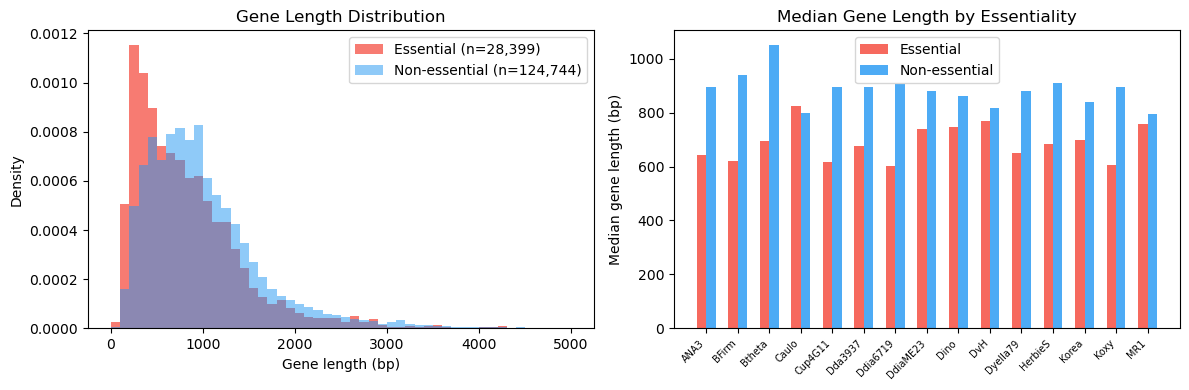

Mann-Whitney U test (essential vs non-essential lengths): p=0.00e+00
Essential median: 690 bp, Non-essential median: 882 bp


In [3]:
# Validation: gene length distribution of essential vs non-essential
# If essentials are systematically shorter, suggests insertion bias
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ess_lengths = essential[essential['is_essential']]['gene_length']
non_ess_lengths = essential[~essential['is_essential']]['gene_length']

axes[0].hist(ess_lengths, bins=50, alpha=0.7, label=f'Essential (n={len(ess_lengths):,})',
             range=(0, 5000), density=True, color='#F44336')
axes[0].hist(non_ess_lengths, bins=50, alpha=0.5, label=f'Non-essential (n={len(non_ess_lengths):,})',
             range=(0, 5000), density=True, color='#2196F3')
axes[0].set_xlabel('Gene length (bp)')
axes[0].set_ylabel('Density')
axes[0].set_title('Gene Length Distribution')
axes[0].legend()

# Box plot per organism
length_data = []
for orgId in sorted(essential['orgId'].unique())[:15]:  # first 15
    org = essential[essential['orgId'] == orgId]
    length_data.append({
        'orgId': orgId,
        'essential_median': org[org['is_essential']]['gene_length'].median(),
        'non_essential_median': org[~org['is_essential']]['gene_length'].median()
    })
ld = pd.DataFrame(length_data)

x = range(len(ld))
axes[1].bar([i-0.15 for i in x], ld['essential_median'], 0.3, label='Essential', color='#F44336', alpha=0.8)
axes[1].bar([i+0.15 for i in x], ld['non_essential_median'], 0.3, label='Non-essential', color='#2196F3', alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(ld['orgId'], rotation=45, ha='right', fontsize=7)
axes[1].set_ylabel('Median gene length (bp)')
axes[1].set_title('Median Gene Length by Essentiality')
axes[1].legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'essential_length_validation.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistical test
stat, p = stats.mannwhitneyu(ess_lengths, non_ess_lengths, alternative='two-sided')
print(f"Mann-Whitney U test (essential vs non-essential lengths): p={p:.2e}")
print(f"Essential median: {ess_lengths.median():.0f} bp, Non-essential median: {non_ess_lengths.median():.0f} bp")

## 2. Join Essential Status with Conservation

In [4]:
# Merge essential gene data with link table
merged = essential.merge(
    link[['orgId', 'locusId', 'gene_cluster_id', 'gtdb_species_clade_id',
          'pident', 'is_core', 'is_auxiliary', 'is_singleton']],
    on=['orgId', 'locusId'],
    how='left'
)

merged['is_mapped'] = merged['gene_cluster_id'].notna()

# Four categories
merged['category'] = 'unknown'
merged.loc[merged['is_essential'] & merged['is_mapped'], 'category'] = 'essential_mapped'
merged.loc[merged['is_essential'] & ~merged['is_mapped'], 'category'] = 'essential_unmapped'
merged.loc[~merged['is_essential'] & merged['is_mapped'], 'category'] = 'nonessential_mapped'
merged.loc[~merged['is_essential'] & ~merged['is_mapped'], 'category'] = 'nonessential_unmapped'

print("=== GENE CATEGORIES ===")
cat_counts = merged['category'].value_counts()
for cat, count in cat_counts.items():
    pct = count / len(merged) * 100
    print(f"  {cat:30s} {count:>8,}  ({pct:.1f}%)")

print(f"\nEssential + unmapped genes: {cat_counts.get('essential_unmapped', 0):,}")
print("  These are strain-specific essential genes — present in the FB strain")
print("  but without a close match in the pangenome cluster representatives.")
print("  They may represent recently acquired essential functions.")

=== GENE CATEGORIES ===
  nonessential_mapped             117,916  (77.0%)
  essential_mapped                 26,434  (17.3%)
  nonessential_unmapped             6,828  (4.5%)
  essential_unmapped                1,965  (1.3%)

Essential + unmapped genes: 1,965
  These are strain-specific essential genes — present in the FB strain
  but without a close match in the pangenome cluster representatives.
  They may represent recently acquired essential functions.


In [5]:
# Per-organism category breakdown
cat_by_org = merged.groupby(['orgId', 'category']).size().unstack(fill_value=0)
cat_by_org['total'] = cat_by_org.sum(axis=1)

# Percentage of essential genes that are mapped vs unmapped
if 'essential_mapped' in cat_by_org.columns and 'essential_unmapped' in cat_by_org.columns:
    cat_by_org['essential_mapped_pct'] = (
        cat_by_org['essential_mapped'] /
        (cat_by_org['essential_mapped'] + cat_by_org['essential_unmapped']) * 100
    ).round(1)

print("=== PER-ORGANISM CATEGORY BREAKDOWN ===")
print(cat_by_org.to_string())

=== PER-ORGANISM CATEGORY BREAKDOWN ===
category           essential_mapped  essential_unmapped  nonessential_mapped  nonessential_unmapped  total  essential_mapped_pct
orgId                                                                                                                           
ANA3                            706                  11                 3609                     34   4360                  98.5
BFirm                          1698                  62                 5318                    104   7182                  96.5
Btheta                          739                  23                 3988                     66   4816                  97.0
Caulo                           546                  35                 3152                    153   3886                  94.0
Cup4G11                         952                  33                 6235                    138   7358                  96.6
Dda3937                         578                  21  

## 3. Core Question: Are Essential Genes More Conserved?

In [6]:
# For mapped genes only, compare conservation between essential and non-essential
mapped = merged[merged['is_mapped']].copy()

results = []
for orgId in sorted(mapped['orgId'].unique()):
    org = mapped[mapped['orgId'] == orgId]
    
    ess = org[org['is_essential']]
    non_ess = org[~org['is_essential']]
    
    if len(ess) < 5 or len(non_ess) < 5:
        continue
    
    ess_core = ess['is_core'].sum()
    ess_not_core = len(ess) - ess_core
    non_core = non_ess['is_core'].sum()
    non_not_core = len(non_ess) - non_core
    
    # Fisher's exact test
    table = [[ess_core, ess_not_core], [non_core, non_not_core]]
    odds_ratio, p_value = stats.fisher_exact(table)
    
    results.append({
        'orgId': orgId,
        'n_essential': len(ess),
        'n_nonessential': len(non_ess),
        'ess_pct_core': round(ess_core / len(ess) * 100, 1),
        'non_ess_pct_core': round(non_core / len(non_ess) * 100, 1),
        'odds_ratio': round(odds_ratio, 2),
        'p_value': p_value,
        'significant': p_value < 0.05
    })

results_df = pd.DataFrame(results).sort_values('odds_ratio', ascending=False)

print("=== ESSENTIAL vs CORE: FISHER'S EXACT TEST ===")
print(results_df.to_string(index=False))
print(f"\nSignificant (p<0.05): {results_df['significant'].sum()}/{len(results_df)}")
print(f"Median odds ratio: {results_df['odds_ratio'].median():.2f}")
print(f"Mean essential %core: {results_df['ess_pct_core'].mean():.1f}%")
print(f"Mean non-essential %core: {results_df['non_ess_pct_core'].mean():.1f}%")

# Save summary
results_df.to_csv(DATA_DIR / 'essential_conservation_summary.tsv', sep='\t', index=False)

=== ESSENTIAL vs CORE: FISHER'S EXACT TEST ===
            orgId  n_essential  n_nonessential  ess_pct_core  non_ess_pct_core  odds_ratio      p_value  significant
            Ponti          559            3579         100.0              99.7         inf 3.763034e-01        False
 Methanococcus_S2          495            1219          95.4              79.7        5.21 2.004524e-18         True
   RalstoniaPSI07          727            3599          94.4              83.1        3.41 2.181566e-17         True
           Marino          690            3526          89.3              73.0        3.08 1.603294e-22         True
          HerbieS          824            3821          93.9              84.2        2.89 4.911587e-15         True
               PS          885            2526          89.6              76.7        2.62 4.063831e-18         True
            Phaeo          773            3050          93.0              85.1        2.33 1.086378e-09         True
           WCS417

/opt/conda/lib/python3.13/site-packages/matplotlib/transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),
/opt/conda/lib/python3.13/site-packages/matplotlib/transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),


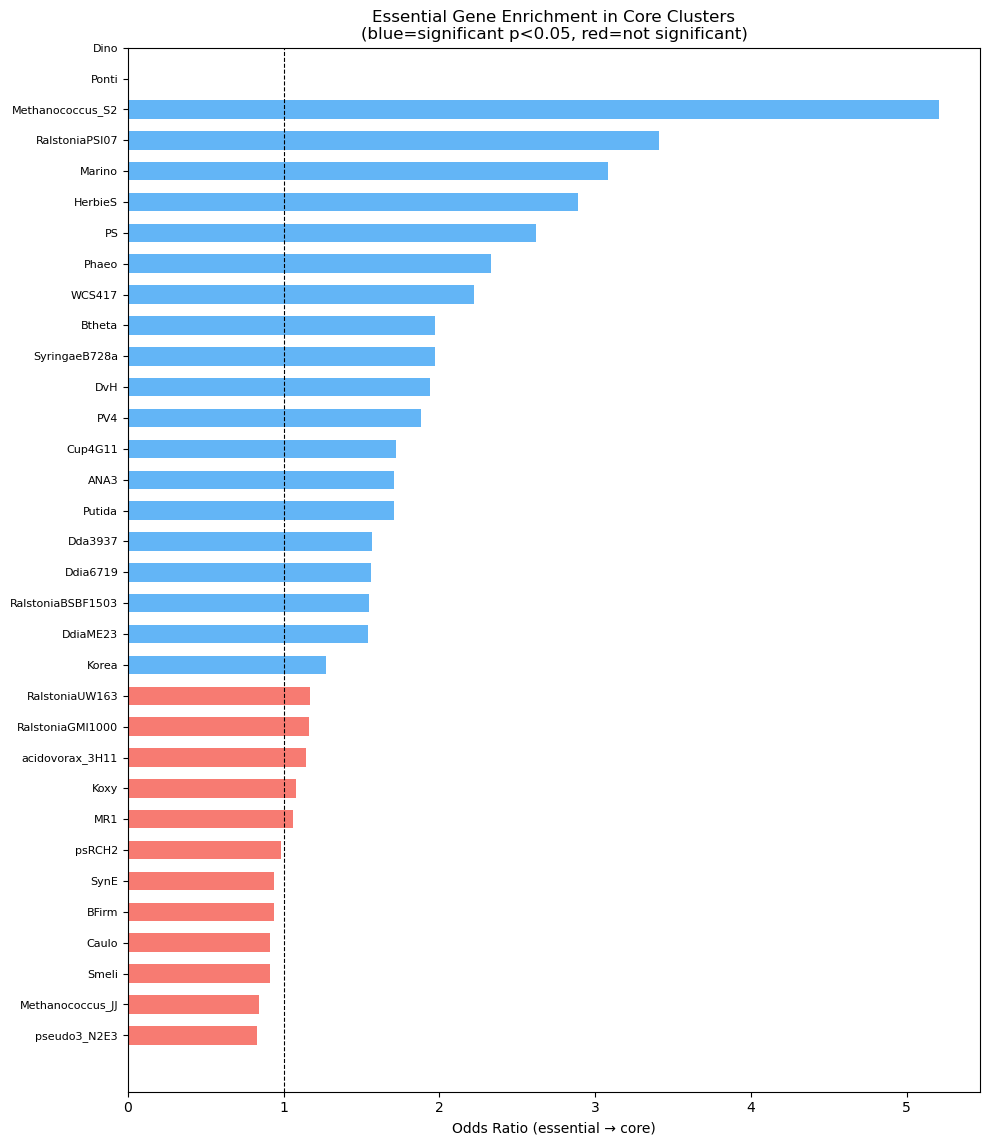

In [7]:
# Forest plot of odds ratios
fig, ax = plt.subplots(figsize=(10, max(6, len(results_df) * 0.35)))

plot_df = results_df.sort_values('odds_ratio')
y_pos = range(len(plot_df))

colors = ['#F44336' if not sig else '#2196F3' for sig in plot_df['significant']]
ax.barh(y_pos, plot_df['odds_ratio'], color=colors, alpha=0.7, height=0.6)
ax.axvline(x=1, color='black', linestyle='--', linewidth=0.8, label='OR=1 (no enrichment)')
ax.set_yticks(y_pos)
ax.set_yticklabels(plot_df['orgId'], fontsize=8)
ax.set_xlabel('Odds Ratio (essential → core)')
ax.set_title('Essential Gene Enrichment in Core Clusters\n(blue=significant p<0.05, red=not significant)')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'essential_vs_core_forest_plot.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Stratify by Pangenome Context

Organisms with pangenome metadata: 33/33


/tmp/ipykernel_109376/356831624.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[2].boxplot(bin_data, labels=bin_labels_present[:len(bin_data)])
/opt/conda/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4674: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


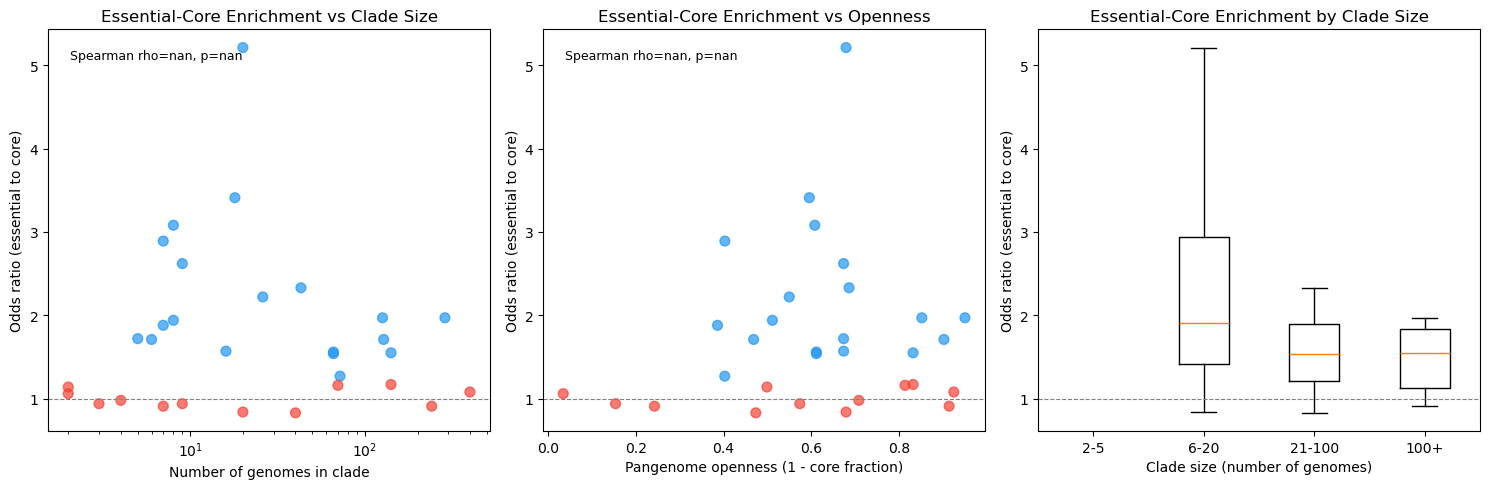

In [8]:
# Add pangenome metadata to results
# Get resolved clade per organism from link table
org_clade = link.drop_duplicates('orgId')[['orgId', 'gtdb_species_clade_id']]
results_enriched = results_df.merge(org_clade, on='orgId', how='left')
results_enriched = results_enriched.merge(pg_meta, on='gtdb_species_clade_id', how='left')

# Compute openness metrics
results_enriched['core_fraction'] = results_enriched['no_core'] / results_enriched['no_gene_clusters']
results_enriched['singleton_fraction'] = results_enriched['no_singleton_gene_clusters'] / results_enriched['no_gene_clusters']
results_enriched['openness'] = 1 - results_enriched['core_fraction']

# Drop rows without pangenome data
re_valid = results_enriched.dropna(subset=['no_genomes', 'openness'])
print(f"Organisms with pangenome metadata: {len(re_valid)}/{len(results_enriched)}")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Odds ratio vs clade size
axes[0].scatter(re_valid['no_genomes'], re_valid['odds_ratio'],
                c=re_valid['significant'].map({True: '#2196F3', False: '#F44336'}),
                alpha=0.7, s=50)
axes[0].axhline(y=1, color='gray', linestyle='--', linewidth=0.8)
axes[0].set_xlabel('Number of genomes in clade')
axes[0].set_ylabel('Odds ratio (essential to core)')
axes[0].set_title('Essential-Core Enrichment vs Clade Size')
if re_valid['no_genomes'].max() > 10:
    axes[0].set_xscale('log')

rho, p = stats.spearmanr(re_valid['no_genomes'], re_valid['odds_ratio'])
axes[0].text(0.05, 0.95, f'Spearman rho={rho:.2f}, p={p:.3f}',
             transform=axes[0].transAxes, fontsize=9, va='top')

# 2. Odds ratio vs openness
axes[1].scatter(re_valid['openness'], re_valid['odds_ratio'],
                c=re_valid['significant'].map({True: '#2196F3', False: '#F44336'}),
                alpha=0.7, s=50)
axes[1].axhline(y=1, color='gray', linestyle='--', linewidth=0.8)
axes[1].set_xlabel('Pangenome openness (1 - core fraction)')
axes[1].set_ylabel('Odds ratio (essential to core)')
axes[1].set_title('Essential-Core Enrichment vs Openness')

rho2, p2 = stats.spearmanr(re_valid['openness'], re_valid['odds_ratio'])
axes[1].text(0.05, 0.95, f'Spearman rho={rho2:.2f}, p={p2:.3f}',
             transform=axes[1].transAxes, fontsize=9, va='top')

# 3. Clade size bins
bins = [0, 5, 20, 100, 100000]
labels = ['2-5', '6-20', '21-100', '100+']
re_valid = re_valid.copy()
re_valid['size_bin'] = pd.cut(re_valid['no_genomes'], bins=bins, labels=labels)

bin_groups = re_valid.groupby('size_bin', observed=True)['odds_ratio']
bin_labels_present = [lbl for lbl in labels if lbl in re_valid['size_bin'].values]
bin_data = [re_valid[re_valid['size_bin'] == lbl]['odds_ratio'].values for lbl in bin_labels_present]
bin_data = [d for d in bin_data if len(d) > 0]

if bin_data:
    axes[2].boxplot(bin_data, labels=bin_labels_present[:len(bin_data)])
    axes[2].axhline(y=1, color='gray', linestyle='--', linewidth=0.8)
axes[2].set_xlabel('Clade size (number of genomes)')
axes[2].set_ylabel('Odds ratio (essential to core)')
axes[2].set_title('Essential-Core Enrichment by Clade Size')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'essential_enrichment_by_context.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Stratify by Organism Lifestyle

Manual classification of the 34 high-coverage organisms.

Organisms with lifestyle: 33/33
Lifestyle classification:
lifestyle
environmental      10
plant_pathogen      8
aquatic             7
anaerobe            3
host_associated     2
symbiont            2
phototroph          1


/tmp/ipykernel_109376/3109028340.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(ls_data, labels=ls_labels_filtered)


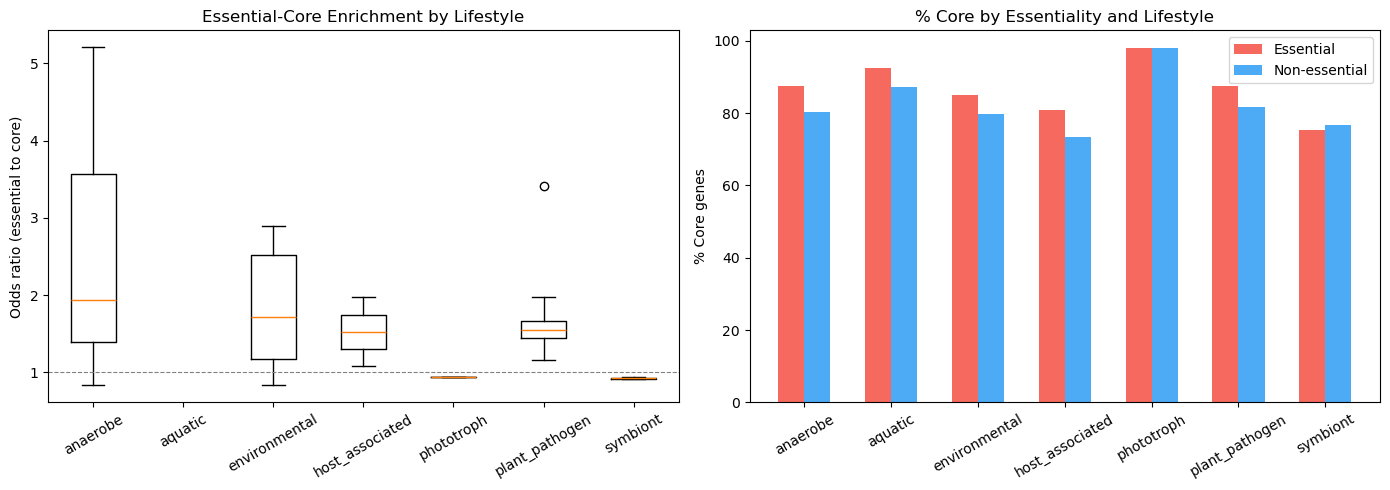

In [9]:
# Manual lifestyle classification based on known biology
lifestyle = {
    # Plant pathogens
    'RalstoniaGMI1000': 'plant_pathogen', 'RalstoniaBSBF1503': 'plant_pathogen',
    'RalstoniaPSI07': 'plant_pathogen', 'RalstoniaUW163': 'plant_pathogen',
    'SyringaeB728a': 'plant_pathogen',
    'Dda3937': 'plant_pathogen', 'Ddia6719': 'plant_pathogen', 'DdiaME23': 'plant_pathogen',
    # Environmental / soil / water
    'Putida': 'environmental', 'psRCH2': 'environmental', 'Cup4G11': 'environmental',
    'Dyella79': 'environmental', 'acidovorax_3H11': 'environmental',
    'PS': 'environmental', 'HerbieS': 'environmental',
    'pseudo3_N2E3': 'environmental', 'WCS417': 'environmental',
    'Korea': 'environmental', 'Ponti': 'environmental',
    # Aquatic / marine
    'MR1': 'aquatic', 'ANA3': 'aquatic', 'PV4': 'aquatic',
    'Marino': 'aquatic', 'Phaeo': 'aquatic', 'Dino': 'aquatic', 'Caulo': 'aquatic',
    # Host-associated / symbiont
    'Btheta': 'host_associated', 'Smeli': 'symbiont', 'azobra': 'symbiont',
    'BFirm': 'symbiont', 'Koxy': 'host_associated',
    # Anaerobe / extremophile
    'DvH': 'anaerobe', 'Methanococcus_JJ': 'anaerobe', 'Methanococcus_S2': 'anaerobe',
    'SynE': 'phototroph',
}

results_enriched['lifestyle'] = results_enriched['orgId'].map(lifestyle)

# Drop organisms without lifestyle assignment
results_with_ls = results_enriched.dropna(subset=['lifestyle'])
print(f"Organisms with lifestyle: {len(results_with_ls)}/{len(results_enriched)}")
print("Lifestyle classification:")
print(results_with_ls['lifestyle'].value_counts().to_string())

# Box plot by lifestyle
ls_labels = sorted(results_with_ls['lifestyle'].unique())
ls_data = [results_with_ls[results_with_ls['lifestyle'] == ls]['odds_ratio'].values
           for ls in ls_labels]
ls_data = [d for d in ls_data if len(d) > 0]
ls_labels_filtered = [ls for ls, d in zip(ls_labels,
    [results_with_ls[results_with_ls['lifestyle'] == ls] for ls in ls_labels]) if len(d) > 0]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].boxplot(ls_data, labels=ls_labels_filtered)
axes[0].axhline(y=1, color='gray', linestyle='--', linewidth=0.8)
axes[0].set_ylabel('Odds ratio (essential to core)')
axes[0].set_title('Essential-Core Enrichment by Lifestyle')
axes[0].tick_params(axis='x', rotation=30)

# % core by lifestyle and essentiality
ess_by_ls = results_with_ls.groupby('lifestyle')['ess_pct_core'].mean()
non_by_ls = results_with_ls.groupby('lifestyle')['non_ess_pct_core'].mean()

x = range(len(ls_labels_filtered))
axes[1].bar([i-0.15 for i in x], [ess_by_ls.get(ls, 0) for ls in ls_labels_filtered],
            0.3, label='Essential', color='#F44336', alpha=0.8)
axes[1].bar([i+0.15 for i in x], [non_by_ls.get(ls, 0) for ls in ls_labels_filtered],
            0.3, label='Non-essential', color='#2196F3', alpha=0.8)
axes[1].set_xticks(list(x))
axes[1].set_xticklabels(ls_labels_filtered, rotation=30)
axes[1].set_ylabel('% Core genes')
axes[1].set_title('% Core by Essentiality and Lifestyle')
axes[1].legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'essential_enrichment_by_lifestyle.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Functional Enrichment of Essential Genes

In [10]:
# Load SEED annotations
seed_path = DATA_DIR / 'seed_annotations.tsv'
if seed_path.exists():
    seed = pd.read_csv(seed_path, sep='\t')
    
    # Join with essentiality
    seed_ess = seed.merge(essential[['orgId', 'locusId', 'is_essential']],
                          on=['orgId', 'locusId'], how='inner')
    
    # Top SEED categories in essential vs non-essential
    ess_seed = seed_ess[seed_ess['is_essential']]['seed_desc'].value_counts().head(20)
    non_ess_seed = seed_ess[~seed_ess['is_essential']]['seed_desc'].value_counts().head(20)
    
    print("=== TOP SEED ANNOTATIONS IN ESSENTIAL GENES ===")
    print(ess_seed.to_string())
    print(f"\n=== TOP SEED ANNOTATIONS IN NON-ESSENTIAL GENES ===")
    print(non_ess_seed.to_string())
    
    # Compute enrichment: fraction of each SEED desc that is essential
    seed_counts = seed_ess.groupby('seed_desc').agg(
        n_total=('locusId', 'size'),
        n_essential=('is_essential', 'sum')
    ).reset_index()
    seed_counts['pct_essential'] = (seed_counts['n_essential'] / seed_counts['n_total'] * 100).round(1)
    seed_counts = seed_counts[seed_counts['n_total'] >= 10]  # filter for statistical power
    
    print(f"\n=== SEED CATEGORIES MOST ENRICHED IN ESSENTIALS (n>=10) ===")
    print(seed_counts.sort_values('pct_essential', ascending=False).head(20).to_string(index=False))
    
    print(f"\n=== SEED CATEGORIES LEAST ENRICHED IN ESSENTIALS ===")
    print(seed_counts.sort_values('pct_essential', ascending=True).head(20).to_string(index=False))
else:
    print("No SEED annotations file found. Run extract_essential_genes.py first.")

=== TOP SEED ANNOTATIONS IN ESSENTIAL GENES ===
seed_desc
Mobile element protein                                                              863
Probable transmembrane protein                                                       74
3-oxoacyl-[acyl-carrier protein] reductase (EC 1.1.1.100)                            59
Chromosomal replication initiator protein DnaA                                       51
Translation elongation factor Tu                                                     49
Protein export cytoplasm protein SecA ATPase RNA helicase (TC 3.A.5.1.1)             45
MotA/TolQ/ExbB proton channel family protein                                         44
Transcriptional regulator, MarR family                                               44
Biopolymer transport protein ExbD/TolR                                               43
Acyl carrier protein                                                                 40
2-octaprenyl-3-methyl-6-methoxy-1,4-benzoquinol hydroxylase (E

In [11]:
# Load KEGG annotations
kegg_path = DATA_DIR / 'kegg_annotations.tsv'
if kegg_path.exists():
    kegg = pd.read_csv(kegg_path, sep='\t')
    
    # Join with essentiality
    kegg_ess = kegg.merge(essential[['orgId', 'locusId', 'is_essential']],
                          on=['orgId', 'locusId'], how='inner')
    
    # KEGG group enrichment
    kegg_counts = kegg_ess.groupby('kegg_desc').agg(
        n_total=('locusId', 'size'),
        n_essential=('is_essential', 'sum')
    ).reset_index()
    kegg_counts['pct_essential'] = (kegg_counts['n_essential'] / kegg_counts['n_total'] * 100).round(1)
    kegg_counts = kegg_counts[kegg_counts['n_total'] >= 10]
    
    print("=== KEGG GROUPS MOST ENRICHED IN ESSENTIALS (n>=10) ===")
    print(kegg_counts.sort_values('pct_essential', ascending=False).head(20).to_string(index=False))
else:
    print("No KEGG annotations file found. Run extract_essential_genes.py first.")

=== KEGG GROUPS MOST ENRICHED IN ESSENTIALS (n>=10) ===
                                                                                                           kegg_desc  n_total  n_essential  pct_essential
                                                              (E)-4-hydroxy-3-methylbut-2-enyl-diphosphate synthase        32           32          100.0
UDP-N-acetylglucosamine--N-acetylmuramyl-(pentapeptide) pyrophosphoryl-undecaprenol N-acetylglucosamine transferase        32           32          100.0
                                                                                 small subunit ribosomal protein S10       34           34          100.0
                                                                                 UDP-N-acetylmuramate dehydrogenase        31           31          100.0
                                                                                  rod shape determining protein RodA       31           31          100.0
                    

## 7. Summary

## 8. Functional Analysis by Conservation Category

Deeper functional characterization of essential genes, broken down by their
conservation status: essential-core, essential-auxiliary, essential-unmapped,
and non-essential baseline.

Data sources: FB SEED annotations (`seedannotation` → `seedannotationtoroles` → `seedroles`),
KEGG annotations (`besthitkegg` → `keggmember` → `kgroupdesc`), gene descriptions.

In [12]:
import re

# Load SEED hierarchy
seed_hier = pd.read_csv(DATA_DIR / 'seed_hierarchy.tsv', sep='\t')
print(f"SEED hierarchy: {len(seed_hier)} seed_desc -> toplevel mappings")

# Build the 4-way merged dataset
# Start from the merged dataset (essential + link table) created in Section 2
# Add SEED annotations
seed = pd.read_csv(DATA_DIR / 'seed_annotations.tsv', sep='\t')
func = merged.merge(seed, on=['orgId', 'locusId'], how='left')

# Add SEED hierarchy (a seed_desc can map to multiple toplevel categories;
# take the first one to avoid duplication)
seed_hier_dedup = seed_hier.drop_duplicates(subset='seed_desc', keep='first')
func = func.merge(seed_hier_dedup[['seed_desc', 'toplevel', 'category', 'subsystem']],
                   on='seed_desc', how='left')

# Debug: check is_core distribution before assignment
print(f"\nis_core distribution in func (mapped genes only):")
mapped_mask = func['is_mapped']
print(f"  True: {(func.loc[mapped_mask, 'is_core'] == True).sum():,}")
print(f"  False: {(func.loc[mapped_mask, 'is_core'] == False).sum():,}")
print(f"  NaN: {func.loc[mapped_mask, 'is_core'].isna().sum():,}")

# Assign conservation category — use explicit boolean checks
func['conservation_category'] = 'nonessential'

# Essential + unmapped (no pangenome cluster match)
mask_ess_unmapped = func['is_essential'] & ~func['is_mapped']
func.loc[mask_ess_unmapped, 'conservation_category'] = 'essential_unmapped'

# Essential + mapped + core
mask_ess_core = func['is_essential'] & func['is_mapped'] & (func['is_core'] == True)
func.loc[mask_ess_core, 'conservation_category'] = 'essential_core'

# Essential + mapped + NOT core (auxiliary or singleton)
mask_ess_aux = func['is_essential'] & func['is_mapped'] & (func['is_core'] != True)
func.loc[mask_ess_aux, 'conservation_category'] = 'essential_auxiliary'

print(f"\nConservation categories:")
print(func['conservation_category'].value_counts().to_string())

# Parse EC numbers from seed_desc
func['has_ec'] = func['seed_desc'].str.contains(r'\(EC [\d\.\-]+\)', na=False)
func['has_annotation'] = func['seed_desc'].notna()

# Enzyme classification
func['enzyme_status'] = 'unannotated'
func.loc[func['has_annotation'] & ~func['has_ec'], 'enzyme_status'] = 'non-enzyme'
func.loc[func['has_ec'], 'enzyme_status'] = 'enzyme'

print(f"\nAnnotation coverage:")
print(func.groupby('conservation_category')['has_annotation'].mean().round(3).to_string())

SEED hierarchy: 5774 seed_desc -> toplevel mappings



is_core distribution in func (mapped genes only):
  True: 118,536
  False: 25,814
  NaN: 0



Conservation categories:
conservation_category
nonessential           124744
essential_core          22751
essential_auxiliary      3683
essential_unmapped       1965



Annotation coverage:
conservation_category
essential_auxiliary    0.640
essential_core         0.923
essential_unmapped     0.519
nonessential           0.808


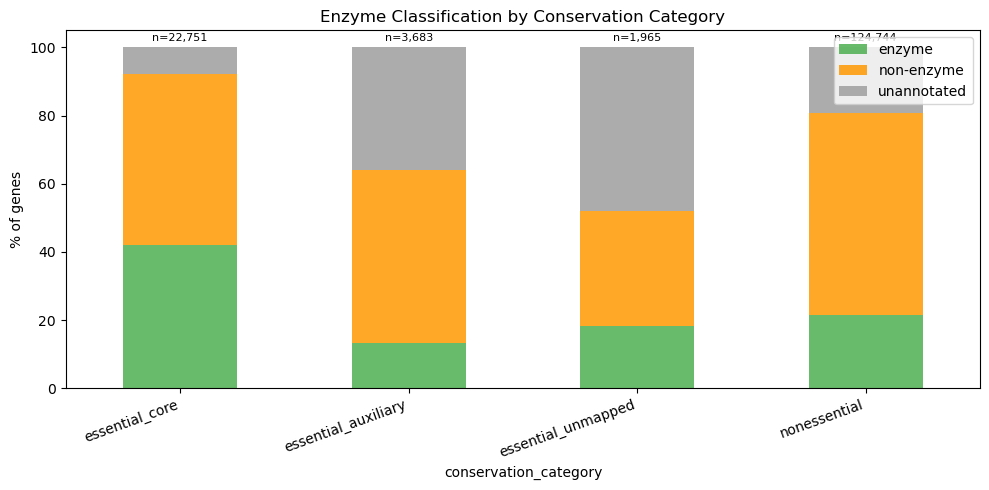

=== ENZYME CLASSIFICATION BY CONSERVATION CATEGORY ===
enzyme_status          enzyme  non-enzyme  unannotated
conservation_category                                 
essential_core           41.9        50.4          7.7
essential_auxiliary      13.4        50.7         36.0
essential_unmapped       18.2        33.6         48.1
nonessential             21.5        59.2         19.2


In [13]:
# Enzyme vs non-enzyme by conservation category
enzyme_ct = pd.crosstab(func['conservation_category'], func['enzyme_status'], normalize='index') * 100

cat_order = ['essential_core', 'essential_auxiliary', 'essential_unmapped', 'nonessential']
enzyme_ct = enzyme_ct.reindex([c for c in cat_order if c in enzyme_ct.index])

fig, ax = plt.subplots(figsize=(10, 5))
enzyme_ct[['enzyme', 'non-enzyme', 'unannotated']].plot(kind='bar', stacked=True, ax=ax,
    color=['#4CAF50', '#FF9800', '#9E9E9E'], alpha=0.85)
ax.set_ylabel('% of genes')
ax.set_title('Enzyme Classification by Conservation Category')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')
ax.legend(title='', loc='upper right')

# Add counts on bars
for i, cat in enumerate(enzyme_ct.index):
    n = (func['conservation_category'] == cat).sum()
    ax.text(i, 102, f'n={n:,}', ha='center', fontsize=8)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'essential_enzyme_breakdown.png', dpi=150, bbox_inches='tight')
plt.show()

print("=== ENZYME CLASSIFICATION BY CONSERVATION CATEGORY ===")
print(enzyme_ct.round(1).to_string())

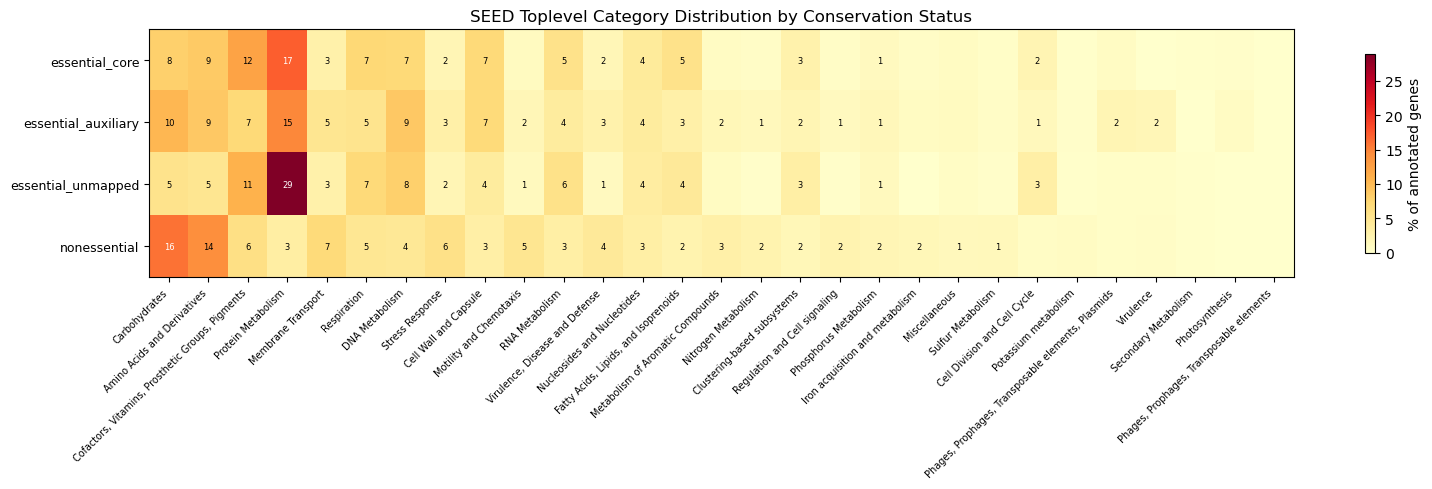

=== SEED TOPLEVEL: ESSENTIAL-CORE vs NON-ESSENTIAL ===
Enriched in essential-core (vs non-essential):
toplevel
Protein Metabolism                                  13.7
Cofactors, Vitamins, Prosthetic Groups, Pigments     6.2
Cell Wall and Capsule                                3.9
Fatty Acids, Lipids, and Isoprenoids                 3.1
DNA Metabolism                                       2.6
Respiration                                          2.5
RNA Metabolism                                       2.3
Cell Division and Cell Cycle                         1.4
Clustering-based subsystems                          1.0
Nucleosides and Nucleotides                          0.9

Depleted in essential-core:
toplevel
Carbohydrates                      -7.9
Amino Acids and Derivatives        -5.6
Membrane Transport                 -4.0
Motility and Chemotaxis            -3.9
Stress Response                    -3.8
Virulence, Disease and Defense     -2.5
Metabolism of Aromatic Compounds   -2.3
N

In [14]:
# SEED toplevel category breakdown by conservation category
annotated = func[func['toplevel'].notna()]

toplevel_ct = pd.crosstab(annotated['conservation_category'], annotated['toplevel'],
                           normalize='index') * 100
toplevel_ct = toplevel_ct.reindex([c for c in cat_order if c in toplevel_ct.index])

# Sort columns by overall frequency
col_order = annotated['toplevel'].value_counts().index.tolist()
toplevel_ct = toplevel_ct[[c for c in col_order if c in toplevel_ct.columns]]

# Heatmap
fig, ax = plt.subplots(figsize=(16, 5))
im = ax.imshow(toplevel_ct.values, cmap='YlOrRd', aspect='auto')
ax.set_xticks(range(len(toplevel_ct.columns)))
ax.set_xticklabels(toplevel_ct.columns, rotation=45, ha='right', fontsize=7)
ax.set_yticks(range(len(toplevel_ct.index)))
ax.set_yticklabels(toplevel_ct.index, fontsize=9)
plt.colorbar(im, label='% of annotated genes', shrink=0.8)
ax.set_title('SEED Toplevel Category Distribution by Conservation Status')

# Add text values
for i in range(len(toplevel_ct.index)):
    for j in range(len(toplevel_ct.columns)):
        val = toplevel_ct.iloc[i, j]
        if val >= 1:
            ax.text(j, i, f'{val:.0f}', ha='center', va='center', fontsize=6,
                    color='white' if val > 15 else 'black')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'essential_seed_toplevel_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# Show top categories enriched in essential-core vs non-essential
print("=== SEED TOPLEVEL: ESSENTIAL-CORE vs NON-ESSENTIAL ===")
if 'essential_core' in toplevel_ct.index and 'nonessential' in toplevel_ct.index:
    diff = toplevel_ct.loc['essential_core'] - toplevel_ct.loc['nonessential']
    print("Enriched in essential-core (vs non-essential):")
    print(diff.sort_values(ascending=False).head(10).round(1).to_string())
    print("\nDepleted in essential-core:")
    print(diff.sort_values(ascending=True).head(10).round(1).to_string())

In [15]:
# SEED subsystem-level analysis for interesting categories
# Top subsystems in essential-auxiliary (not in all strains but essential)
for cat_label, cat_name in [('essential_auxiliary', 'Essential-Auxiliary'),
                             ('essential_unmapped', 'Essential-Unmapped'),
                             ('essential_core', 'Essential-Core')]:
    cat_data = annotated[annotated['conservation_category'] == cat_label]
    if len(cat_data) == 0:
        continue
    sub_counts = cat_data['subsystem'].value_counts().head(15)
    print(f"\n=== TOP SUBSYSTEMS: {cat_name} (n={len(cat_data)}) ===")
    print(sub_counts.to_string())


=== TOP SUBSYSTEMS: Essential-Auxiliary (n=817) ===
subsystem
Ribosome_LSU_bacterial                       36
Ribosome_SSU_bacterial                       26
DNA-replication                              24
Universal_GTPases                            23
Ton_and_Tol_transport_systems                18
Type_4_secretion_and_conjugative_transfer    14
Fatty_Acid_Biosynthesis_FASII                13
Plasmid_replication                          11
Conjugative_transposon,_Bacteroidales        10
De_Novo_Pyrimidine_Synthesis                 10
Rhamnose_containing_glycans                   9
Terminal_cytochrome_C_oxidases                9
DNA_repair,_bacterial                         9
TCA_Cycle                                     9
Flagellum                                     9

=== TOP SUBSYSTEMS: Essential-Unmapped (n=679) ===
subsystem
Ribosome_LSU_bacterial                                         94
Ribosome_SSU_bacterial                                         53
Respiratory_Complex_I  

In [16]:
# KEGG functional group breakdown by conservation category
kegg = pd.read_csv(DATA_DIR / 'kegg_annotations.tsv', sep='\t')
func_kegg = merged.merge(kegg, on=['orgId', 'locusId'], how='left')
func_kegg['conservation_category'] = 'nonessential'
func_kegg.loc[func_kegg['is_essential'] & func_kegg['is_mapped'],
              'conservation_category'] = 'essential_core'
func_kegg.loc[func_kegg['is_essential'] & func_kegg['is_mapped'] &
              ~func_kegg['is_core'].fillna(False),
              'conservation_category'] = 'essential_auxiliary'
func_kegg.loc[func_kegg['is_essential'] & ~func_kegg['is_mapped'],
              'conservation_category'] = 'essential_unmapped'

kegg_annotated = func_kegg[func_kegg['kegg_desc'].notna()]

kegg_ct = pd.crosstab(kegg_annotated['conservation_category'],
                       kegg_annotated['kegg_desc'], normalize='index') * 100

# Top KEGG groups in essential-core vs nonessential
if 'essential_core' in kegg_ct.index and 'nonessential' in kegg_ct.index:
    kegg_diff = kegg_ct.loc['essential_core'] - kegg_ct.loc['nonessential']
    print("=== KEGG GROUPS: ENRICHED IN ESSENTIAL-CORE ===")
    print(kegg_diff.sort_values(ascending=False).head(15).round(2).to_string())
    print("\n=== KEGG GROUPS: DEPLETED IN ESSENTIAL-CORE ===")
    print(kegg_diff.sort_values(ascending=True).head(15).round(2).to_string())

In [17]:
# Gene description analysis for essential-unmapped genes
# These are strain-specific essential genes — what are they?
unmapped_ess = func[func['conservation_category'] == 'essential_unmapped']
print(f"=== ESSENTIAL-UNMAPPED GENES ({len(unmapped_ess):,}) ===")

# What fraction are hypothetical/uncharacterized?
hypo = unmapped_ess['desc'].str.contains('hypothetical|uncharacterized|unknown|predicted protein',
                                          case=False, na=True)
print(f"\nHypothetical/unknown: {hypo.sum():,} ({hypo.mean()*100:.1f}%)")
print(f"With known function: {(~hypo).sum():,} ({(~hypo).mean()*100:.1f}%)")

# Show known functions
known = unmapped_ess[~hypo]
if len(known) > 0:
    print(f"\nTop descriptions of essential-unmapped genes with known function:")
    print(known['desc'].value_counts().head(20).to_string())

# Compare: what fraction of each category is hypothetical?
print(f"\n=== HYPOTHETICAL FRACTION BY CONSERVATION CATEGORY ===")
for cat in cat_order:
    cat_data = func[func['conservation_category'] == cat]
    if len(cat_data) == 0:
        continue
    h = cat_data['desc'].str.contains('hypothetical|uncharacterized|unknown|predicted protein',
                                       case=False, na=True)
    print(f"  {cat:25s} {h.mean()*100:5.1f}% hypothetical  (n={len(cat_data):,})")

=== ESSENTIAL-UNMAPPED GENES (1,965) ===

Hypothetical/unknown: 879 (44.7%)
With known function: 1,086 (55.3%)

Top descriptions of essential-unmapped genes with known function:
desc
transposase                                       19
50S ribosomal protein L34                          8
acyl carrier protein                               7
translation initiation factor IF-1                 7
membrane protein                                   6
30S ribosomal protein S11                          6
50S ribosomal protein L36                          6
HU family DNA-binding protein                      6
AAA family ATPase                                  6
50S ribosomal protein L18                          5
30S ribosomal protein S12                          5
30S ribosomal protein S14                          5
elongation factor Tu                               5
DNA-directed RNA polymerase subunit alpha          4
NADH-quinone oxidoreductase subunit K              4
flagellar hook-basal b

In [18]:
print("=" * 60)
print("NB04 SUMMARY: Essential Genes vs Conservation")
print("=" * 60)
print(f"Organisms analyzed: {essential['orgId'].nunique()}")
print(f"Total genes: {len(essential):,}")
print(f"Essential genes: {essential['is_essential'].sum():,} ({essential['is_essential'].mean()*100:.1f}%)")
print(f"Non-essential genes: {(~essential['is_essential']).sum():,}")
print()

mapped_ess = merged[(merged['is_essential']) & (merged['is_mapped'])]
mapped_non = merged[(~merged['is_essential']) & (merged['is_mapped'])]
print(f"Essential + mapped to pangenome: {len(mapped_ess):,}")
print(f"  Core: {mapped_ess['is_core'].sum():,} ({mapped_ess['is_core'].mean()*100:.1f}%)")
print(f"  Auxiliary: {mapped_ess['is_auxiliary'].sum():,} ({mapped_ess['is_auxiliary'].mean()*100:.1f}%)")
print(f"  Singleton: {mapped_ess['is_singleton'].sum():,} ({mapped_ess['is_singleton'].mean()*100:.1f}%)")
print()
print(f"Non-essential + mapped to pangenome: {len(mapped_non):,}")
print(f"  Core: {mapped_non['is_core'].sum():,} ({mapped_non['is_core'].mean()*100:.1f}%)")
print(f"  Auxiliary: {mapped_non['is_auxiliary'].sum():,} ({mapped_non['is_auxiliary'].mean()*100:.1f}%)")
print(f"  Singleton: {mapped_non['is_singleton'].sum():,} ({mapped_non['is_singleton'].mean()*100:.1f}%)")
print()

unmapped_ess = merged[(merged['is_essential']) & (~merged['is_mapped'])]
print(f"Essential + unmapped (strain-specific): {len(unmapped_ess):,}")
print()

n_sig = results_df['significant'].sum()
print(f"Fisher's exact test: {n_sig}/{len(results_df)} organisms show significant enrichment (p<0.05)")
print(f"Median odds ratio: {results_df['odds_ratio'].median():.2f}")
print("=" * 60)

NB04 SUMMARY: Essential Genes vs Conservation
Organisms analyzed: 34
Total genes: 153,143
Essential genes: 28,399 (18.5%)
Non-essential genes: 124,744

Essential + mapped to pangenome: 26,434
  Core: 22,751 (86.1%)
  Auxiliary: 3,683 (13.9%)
  Singleton: 1,102 (4.2%)

Non-essential + mapped to pangenome: 117,916
  Core: 95,785 (81.2%)
  Auxiliary: 22,131 (18.8%)
  Singleton: 5,862 (5.0%)

Essential + unmapped (strain-specific): 1,965

Fisher's exact test: 19/33 organisms show significant enrichment (p<0.05)
Median odds ratio: 1.56
